## Setup

In [1]:
# optional env import
from dotenv import load_dotenv
load_dotenv()

True

In [6]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
from ast import literal_eval

In [5]:
import os
from openai import OpenAI
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv()) # read local .env file
openai_api_key = os.getenv('OPENAI_API_KEY')
client = OpenAI(api_key=openai_api_key)

In [13]:
COMPLETIONS_MODEL = "gpt-3.5-turbo"

# This path leads to a file with data and precomputed embeddings
embedding_path = "./movielens_with_embedding.csv"

## Clustering

We'll reuse the approach from the [Clustering Notebook](Clustering.ipynb), using K-Means to cluster our dataset using the feature embeddings we created previously. We'll then use the Completions endpoint to generate cluster descriptions for us and judge their effectiveness

In [15]:
df = pd.read_csv(embedding_path)
df.head()

,Unnamed: 0,movie_id,title,genres,combined,embedding
0,0,1,Toy Story (1995),Animation|Children's|Comedy,movie_id: 1; movie_title: Toy Story (1995); ge...,"[0.01665276288986206, 0.021399104967713356, -0..."
1,1,2,Jumanji (1995),Adventure|Children's|Fantasy,movie_id: 2; movie_title: Jumanji (1995); genr...,"[-0.00014520128024742007, 0.059535060077905655..."
2,2,3,Grumpier Old Men (1995),Comedy|Romance,movie_id: 3; movie_title: Grumpier Old Men (19...,"[-0.03695736825466156, 0.0581425242125988, -0...."
3,3,4,Waiting to Exhale (1995),Comedy|Drama,movie_id: 4; movie_title: Waiting to Exhale (1...,"[-0.0013283734442666173, 0.03428707271814346, ..."
4,4,5,Father of the Bride Part II (1995),Comedy,movie_id: 5; movie_title: Father of the Bride ...,"[-0.006768974009901285, 0.06973537057638168, -..."


In [16]:
embedding_df = pd.read_csv(embedding_path)
embedding_df["embedding"] = embedding_df.embedding.apply(literal_eval).apply(np.array)
matrix = np.vstack(embedding_df.embedding.values)
matrix.shape

(1637, 1536)

In [36]:
n_clusters = 10

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42, n_init=10)
kmeans.fit(matrix)
embedding_df["Cluster"] = kmeans.labels_

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

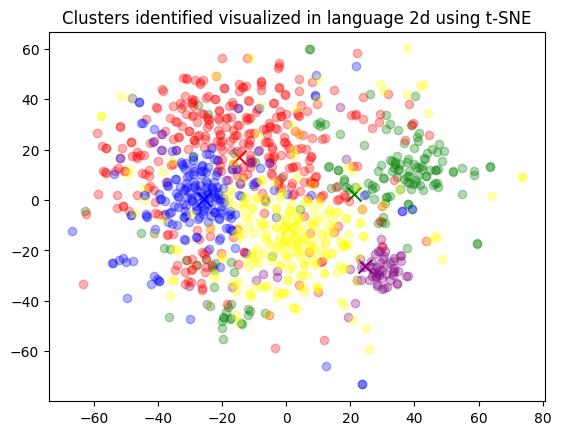

In [37]:
tsne = TSNE(
    n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200
)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue","yellow"]):
    xs = np.array(x)[embedding_df.Cluster == category]
    ys = np.array(y)[embedding_df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")


In [38]:
embedding_df

,Unnamed: 0,movie_id,title,genres,combined,embedding,Cluster
0,0,1,Toy Story (1995),Animation|Children's|Comedy,movie_id: 1; movie_title: Toy Story (1995); ge...,"[0.01665276288986206, 0.021399104967713356, -0...",8
1,1,2,Jumanji (1995),Adventure|Children's|Fantasy,movie_id: 2; movie_title: Jumanji (1995); genr...,"[-0.00014520128024742007, 0.059535060077905655...",8
2,2,3,Grumpier Old Men (1995),Comedy|Romance,movie_id: 3; movie_title: Grumpier Old Men (19...,"[-0.03695736825466156, 0.0581425242125988, -0....",3
3,3,4,Waiting to Exhale (1995),Comedy|Drama,movie_id: 4; movie_title: Waiting to Exhale (1...,"[-0.0013283734442666173, 0.03428707271814346, ...",2
4,4,5,Father of the Bride Part II (1995),Comedy,movie_id: 5; movie_title: Father of the Bride ...,"[-0.006768974009901285, 0.06973537057638168, -...",4
...,...,...,...,...,...,...,...
1632,1632,1678,"Joy Luck Club, The (1993)",Drama,"movie_id: 1678; movie_title: Joy Luck Club, Th...","[-0.019369907677173615, 0.017349185422062874, ...",2
1633,1633,1679,Chairman of the Board (1998),Comedy,movie_id: 1679; movie_title: Chairman of the B...,"[-0.014829746447503567, 0.012682718224823475, ...",4
1634,1634,1680,Sliding Doors (1998),Drama|Romance,movie_id: 1680; movie_title: Sliding Doors (19...,"[-0.04891534894704819, 0.0481468103826046, -0....",3
1635,1635,1681,Mortal Kombat: Annihilation (1997),Action|Adventure,movie_id: 1681; movie_title: Mortal Kombat: An...,"[-0.03004085086286068, 0.1001056358218193, -0....",5


In [39]:
embedding_df['Cluster'].value_counts()

Cluster
2    360
4    267
3    201
7    166
1    151
6    141
8    122
5     84
9     82
0     63
Name: count, dtype: int64

In [40]:
movies_per_cluster = 5

for i in range(n_clusters):
    print(f"Cluster {i} Genres:\n")

    movies = "\n".join(
        embedding_df[embedding_df.Cluster == i]
        .combined
        .sample(movies_per_cluster , random_state=42)
        .values
    )
    response = client.chat.completions.create(
        model=COMPLETIONS_MODEL,
        # We'll include a prompt to instruct the model what sort of description we're looking for
        messages=[
            {"role": "user",
             "content": f'''We want to group these movies into meaningful clusters. 
                What do the following movies have in common?\n\nMovies:\n"""\n{movies}\n"""\n\nGenres:'''}
        ],
        temperature=0,
        max_tokens=100,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response.choices[0].message.content.replace("\n", ""))
    print("\n")

    sample_cluster_rows = embedding_df[embedding_df.Cluster == i].sample(movies_per_cluster, random_state=42)
    for j in range(movies_per_cluster):
        print(sample_cluster_rows.title.values[j], end=", ")
        print(sample_cluster_rows.genres.values[j], end="\n")

    print("-" * 100)
    print("\n")


Cluster 0 Genres:

The commonality among these movies is that they all belong to the genre of Documentary.


Year of the Horse (1997), Documentary
Fire on the Mountain (1996), Documentary
Across the Sea of Time (1995), Documentary
When We Were Kings (1996), Documentary
Jupiter's Wife (1994), Documentary
----------------------------------------------------------------------------------------------------


Cluster 1 Genres:

The common theme among these movies is that they all fall under the genres of Action and Adventure. Some of them also include elements of Thriller and Mystery.


Mission: Impossible (1996), Action|Adventure|Mystery
Crimson Tide (1995), Drama|Thriller|War
Quest, The (1996), Action|Adventure
Substitute, The (1996), Action
Air Force One (1997), Action|Thriller
----------------------------------------------------------------------------------------------------


Cluster 2 Genres:

All of the movies listed have the genre "Drama" in common.


Robin Hood: Prince of Thieves 